In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download gan-getting-started 

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/15.0k [00:00<?, ?B/s]
100% 15.0k/15.0k [00:00<00:00, 13.5MB/s]
  0% 0.00/10.4k [00:00<?, ?B/s]
100% 10.4k/10.4k [00:00<00:00, 11.0MB/s]
  0% 0.00/17.9k [00:00<?, ?B/s]
100% 17.9k/17.9k [00:00<00:00, 18.2MB/s]
  0% 0.00/19.7k [00:00<?, ?B/s]
100% 19.7k/19.7k [00:00<00:00, 20.5MB/s]
  0% 0.00/11.3k [00:00<?, ?B/s]
100% 11.3k/11.3k [00:00<00:00, 11.4MB/s]
  0% 0.00/19.4k [00:00<?, ?B/s]
100% 19.4k/19.4k [00:00<00:00, 20.0MB/s]
  0% 0.00/13.4k [00:00<?, ?B/s]
100% 13.4k/13.4k [00:00<00:00, 12.3MB/s]
  0% 0.00/9.16k [00:00<?, ?B/s]
100% 9.16k/9.16k [00:00<00:00, 7.87MB/s]
  0% 0.00/17.6k [00:00<?, ?B/s]
100% 17.6k/17.6k [00:00<00:00, 15.0MB/s]
  0% 0.00/11.1k [00:00<?, ?B/s]
100% 11.1k/11.1k [00:00<00:00, 11.3MB/s]
  0% 0.00/18.1k [00:00<?, ?B/s]
100% 18.1k/18.1k [00:00<00:00, 18.4MB/s]
  0% 0.00/23.4k [00:00<?, ?B/s]
100% 23.4k/23.4k [00:00<00:00, 21.2MB/s]
  0% 0.00/14.7k [00:00<?, ?B/s]
100% 14.7k/14.7k [00:00<00:00, 7

In [ ]:
!ls *.zip

monet00-60.tfrec.zip   photo04-352.tfrec.zip  photo13-352.tfrec.zip
monet04-60.tfrec.zip   photo05-352.tfrec.zip  photo14-352.tfrec.zip
monet08-60.tfrec.zip   photo06-352.tfrec.zip  photo15-352.tfrec.zip
monet12-60.tfrec.zip   photo07-352.tfrec.zip  photo16-352.tfrec.zip
monet16-60.tfrec.zip   photo08-352.tfrec.zip  photo17-352.tfrec.zip
photo00-352.tfrec.zip  photo09-352.tfrec.zip  photo18-352.tfrec.zip
photo01-352.tfrec.zip  photo10-352.tfrec.zip  photo19-350.tfrec.zip
photo02-352.tfrec.zip  photo11-352.tfrec.zip
photo03-352.tfrec.zip  photo12-352.tfrec.zip


In [ ]:
!mkdir photos

In [ ]:
!unzip '*.zip' -d photos

Archive:  photo02-352.tfrec.zip
  inflating: photos/photo02-352.tfrec  

Archive:  monet12-60.tfrec.zip
  inflating: photos/monet12-60.tfrec  

Archive:  photo00-352.tfrec.zip
  inflating: photos/photo00-352.tfrec  

Archive:  photo10-352.tfrec.zip
  inflating: photos/photo10-352.tfrec  

Archive:  photo04-352.tfrec.zip
  inflating: photos/photo04-352.tfrec  

Archive:  photo06-352.tfrec.zip
  inflating: photos/photo06-352.tfrec  

Archive:  photo07-352.tfrec.zip
  inflating: photos/photo07-352.tfrec  

Archive:  monet08-60.tfrec.zip
  inflating: photos/monet08-60.tfrec  

Archive:  photo16-352.tfrec.zip
  inflating: photos/photo16-352.tfrec  

Archive:  photo18-352.tfrec.zip
  inflating: photos/photo18-352.tfrec  

Archive:  photo09-352.tfrec.zip
  inflating: photos/photo09-352.tfrec  

Archive:  monet16-60.tfrec.zip
  inflating: photos/monet16-60.tfrec  

Archive:  photo15-352.tfrec.zip
  inflating: photos/photo15-352.tfrec  

Archive:  monet00-60.tfrec.zip
  inflating: photos/monet0

In [ ]:
!rm -r *.zip

In [ ]:
!mkdir monet

In [ ]:
!mv *.jpg monet

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 17.9 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.data import Dataset, TFRecordDataset
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import glob
import PIL
import os

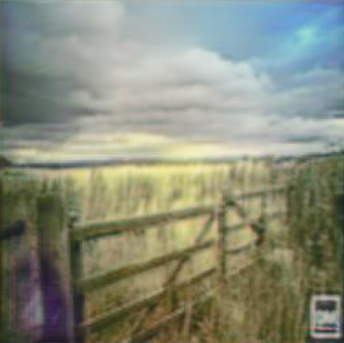


In [ ]:
img_size = (256, 256)

In [ ]:
def get_unet_generator(img_size):

  def downsample_block(input, filters):
    d = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(input)
    d = tfa.layers.InstanceNormalization(axis=3, center=False, scale=False)(d)
    d = layers.LeakyReLU(0.2)(d)
    d = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
    d = tfa.layers.InstanceNormalization(axis=3, center=False, scale=False)(d)
    d = layers.LeakyReLU(0.2)(d)
    d = layers.Conv2D(filters, kernel_size=2, strides=2, padding='valid')(d)

    return d
  
  def residual_block(input, filters):
    residual = input
    y = layers.Conv2D(filters, 3, 1, 'same')(input)
    y = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
    y = layers.LeakyReLU(0.2)(y)

    y = layers.Conv2D(filters, 3, 1, 'same')(y)
    y = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)

    return layers.Add()([residual, y])
  
  def upsample_block(input, concat, filters, upsampling = True):
    u = layers.Concatenate()([concat, input])
    u = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(u)
    u = tfa.layers.InstanceNormalization(axis=3, center=False, scale=False)(u)
    u = layers.LeakyReLU(0.2)(u)
    u = layers.Conv2D(filters // 2, kernel_size=3, strides=1, padding='same')(u)
    u = tfa.layers.InstanceNormalization(axis=3, center=False, scale=False)(u)
    u = layers.LeakyReLU(0.2)(u)

    if upsampling:
      u = layers.UpSampling2D()(u)

    return u
  
  filters = 16

  concat = []
  input = keras.Input(shape=(*img_size, 3))
  x = input
  for i in range(4):
    x = downsample_block(x, filters)
    concat.append(x)
    filters *= 2

  x = layers.LeakyReLU(0.2)(layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x))

  for i in range(8):
    x = residual_block(x, filters)

  x = layers.LeakyReLU(0.2)(layers.Conv2D(filters // 2, kernel_size=4, strides=1, padding='same')(x))
  for i in range(3, -1, -1):
    
    x = upsample_block(x, concat[i], filters)
    filters //= 2
  
  x = layers.LeakyReLU(0.2)(layers.Conv2D(filters, 3, 1, 'same')(x))
  x = layers.LeakyReLU(0.2)(layers.Conv2D(filters, 3, 1, 'same')(x))

  output = layers.Conv2D(3, 1, 1, 'same', activation='tanh')(x)
  model = keras.Model(input, output)

  return model



In [ ]:
def get_discriminator(img_size, n_filters = 64):

  def conv4(input, filters, stride=2, norm=True):
    y = layers.Conv2D(filters, kernel_size=4, strides=1, padding='same')(input)

    if norm:
      y = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
    
    y = layers.LeakyReLU(0.2)(y)

    return y
  
  input = keras.Input(shape=(*img_size, 3))

  y = conv4(input, n_filters, stride=2, norm=False)
  y = conv4(y, n_filters * 2, stride=2)
  y = conv4(y, n_filters * 4, stride=2)
  y = conv4(y, n_filters * 8, stride=1)

  output = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(y)

  return keras.models.Model(input, output)

In [ ]:
disc_M = get_discriminator(img_size)
disc_P = get_discriminator(img_size)

disc_M.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5) ,loss='mse', metrics=['accuracy'])
disc_P.compile(optimizer=keras.optimizers.Adam(0.0002, 0.5), loss='mse', metrics=['accuracy'])

disc_M.trainable = False
disc_P.trainable = False

gen_PM = get_unet_generator(img_size)
gen_MP = get_unet_generator(img_size)

img_M = keras.Input(shape=(*img_size, 3))
img_P = keras.Input(shape=(*img_size, 3))


fake_M = gen_PM(img_P)
fake_P = gen_MP(img_M)

# Are generators good at fooling target discriminators :
valid_M = disc_M(fake_M)
valid_P = disc_P(fake_P)

# Doesn't 2 sucessive generator translations change the original image?  
reconst_M = gen_PM(fake_P)
reconst_P = gen_MP(fake_M)

# Generators don't have to change it's target images
img_P_identity = gen_MP(img_P)
img_M_identity = gen_PM(img_M)

cycle_model = keras.models.Model(inputs=[img_P, img_M],
                                 outputs=[
                                   valid_P,
                                   valid_M,
                                   reconst_P,
                                   reconst_M,
                                   img_P_identity,
                                   img_M_identity
                                 ])
disc_M.trainable = True
disc_P.trainable = True

cycle_model.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                    loss_weights=[1.,1.,10.,10.,1.,1.],
                    optimizer=keras.optimizers.Adam(0.0002, 0.5))


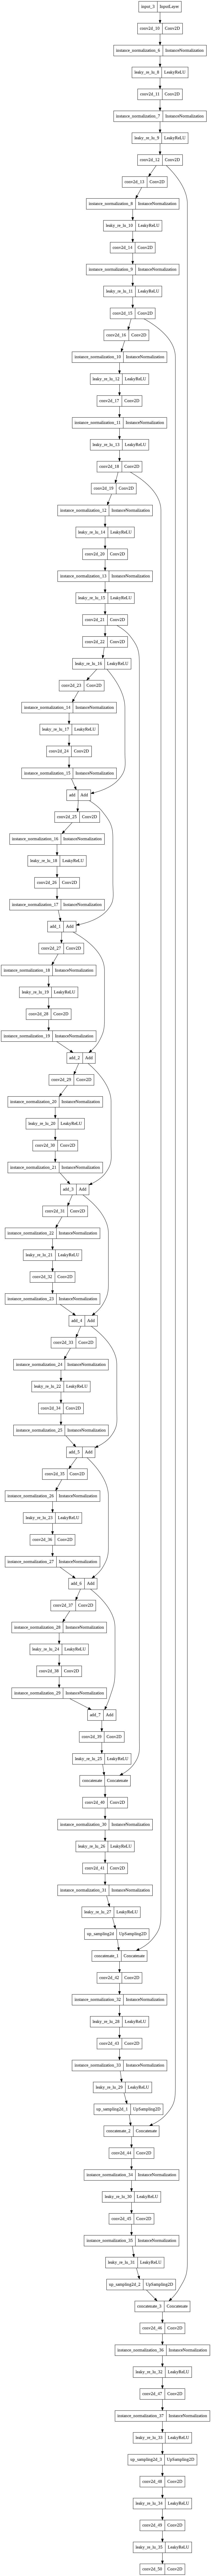

In [ ]:
keras.utils.plot_model(gen_PM, 'generator.png')

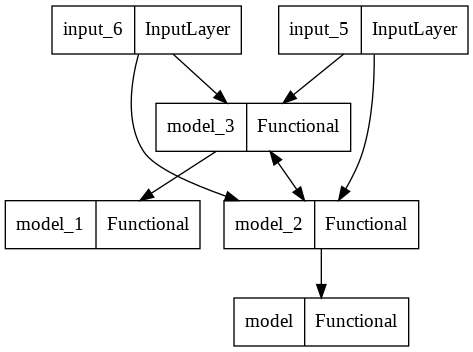

In [ ]:
tf.keras.utils.plot_model(cycle_model, to_file='model.png')

In [ ]:
class DataGenerator(keras.utils.Sequence):

  def __init__(self, monet_path, photo_path, batch_size, img_size, len):
    self.batch_size = batch_size
    self.monet_path = monet_records_pathes
    self.photo_path = photo_path
    self.img_size = img_size
    self.len = len

    self.load_data()
  
  def _parse_function(self, example_proto):
    return tf.io.parse_single_example(example_proto, self.features)
  
  def decode_image(self, image):
    
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1.
    image = tf.reshape(image, (*img_size, 3))
    return image

  def load_data(self):
    self.features = {
      'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
      'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
      'target': tf.io.FixedLenFeature([], tf.string, default_value=''),
    }

    raw_monet_dataset = tf.data.TFRecordDataset(self.monet_path)
    raw_photo_dataset = tf.data.TFRecordDataset(self.photo_path)

    self.parsed_monet_dataset = raw_monet_dataset.map(self._parse_function).shuffle(buffer_size=2048)
    self.parsed_photo_dataset = raw_photo_dataset.map(self._parse_function).shuffle(buffer_size=2048)

  def get_photos(self):
    return self.parsed_photo_dataset

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    P = np.ndarray(shape=(self.batch_size, *self.img_size, 3))
    M = np.ndarray(shape=(self.batch_size, *self.img_size, 3))

    i = 0
    for x in self.parsed_monet_dataset.take(self.batch_size):
      M[i] = self.decode_image(x['image']).numpy().astype('float32')
      i += 1
    
    i = 0
    for x in self.parsed_photo_dataset.take(self.batch_size):
      P[i] = self.decode_image(x['image']).numpy().astype('float32')
      i += 1
    
    return (P, M)
    

In [ ]:
monet_records_pathes = glob.glob('photos/*monet*')
photo_records_pathes = glob.glob('photos/*photo*')

In [ ]:
data_gen = DataGenerator(monet_records_pathes, photo_records_pathes, 1, img_size, 300)

In [ ]:
batch_size = 1
patch = 256
disc_patch = (patch, patch, 1)

valid = np.ones((batch_size, ) + disc_patch)
fake = np.zeros((batch_size, ) + disc_patch)

In [ ]:
history = []

for epoch in range(10):

  for i in range(500):
    img_P, img_M = data_gen[i]

    fake_M = gen_PM(img_P)
    fake_P = gen_MP(img_M)

    dP_loss_real = disc_P.train_on_batch(img_P, valid)
    dP_loss_fake = disc_P.train_on_batch(fake_P, fake)
    dP_loss = 0.5 * np.add(dP_loss_real, dP_loss_fake)

    dM_loss_real = disc_M.train_on_batch(img_M, valid)
    dM_loss_fake = disc_M.train_on_batch(fake_M, fake)
    dM_loss = 0.5 * np.add(dM_loss_real, dM_loss_fake)

    d_loss = 0.5*(dP_loss + dM_loss)

    g_loss = cycle_model.train_on_batch([img_P, img_M],
                                      [valid, valid,
                                       img_P, img_M,
                                       img_P, img_M])
    print(i)
  P, M = data_gen[0]
  img = gen_PM(P)
  PIL.Image.fromarray(((img + 1.0)*127.5)[0].numpy().astype('uint8')).save(f'img{epoch}.jpg')
  history.append([m.result() for m in cycle_model.metrics])
  print(history[-1])
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
P, M = data_gen[0]

In [ ]:
img = gen_PM(P)

In [ ]:
PIL.Image.fromarray(((img + 1.0)*127.5)[0].numpy().astype('uint8')).save('img.jpg')

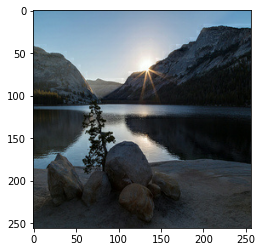

In [ ]:
plt.imshow(((P[0] + 1.0)*127.5).astype('int64'))

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
